In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import auc
import mne
from scipy.stats import ttest_ind

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [22]:
def find_txt_files(directory, step, window, text):
    # List to hold the names of .txt files
    txt_files = []

    # Loop through the files and directories in 'directory'
    for filename in os.listdir(directory):
        # Check if the filename ends with .txt
        if filename.endswith('.txt'):
            if (str(window) + "_" + str(step)) in filename and text in filename:
                txt_files.append(filename)
    
    return txt_files

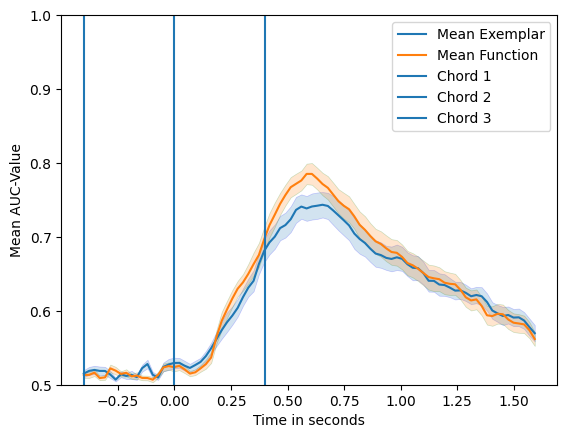

In [30]:
# Step and window size used for generating data
step = 3
window = 7

# Directory where the files are stored
data_dir = "./data"
file_paths = find_txt_files(data_dir, step, window, "auc")

# List to store data from all subjects
all_roc_exemplar = []
all_roc_function = []

bad_subjects = ["040"]


# Process each file
for file_name in file_paths:
    if not any(substring in file_name for substring in bad_subjects):

        file_path = data_dir + "/" + file_name
        if os.path.exists(file_path):
            # Read the data from the file
            data = np.loadtxt(file_path)
            
            # Append the data to the lists
            # all_roc_exemplar.append(abs(np.array(data[:, 0]) - 0.5) + 0.5)
            # all_roc_function.append(abs(np.array(data[:, 1]) - 0.5) + 0.5)
            # print(file_name)

            exemplar = data[:, 0]
            function = data[:, 1]
            exemplar[exemplar < 0.5] = 0.5
            function[function < 0.5] = 0.5

            all_roc_exemplar.append(exemplar)
            all_roc_function.append(function)




# Convert lists to NumPy arrays for efficient computation
all_roc_exemplar = np.array(all_roc_exemplar)
all_roc_function = np.array(all_roc_function)

# Compute the mean values using NumPy
mean_roc_exemplar = np.mean(all_roc_exemplar, axis=0)
mean_roc_function = np.mean(all_roc_function, axis=0)

std_roc_exemplar = np.std(all_roc_exemplar, axis=0) / np.sqrt(len(all_roc_exemplar))
std_roc_function = np.std(all_roc_function, axis=0) / np.sqrt(len(all_roc_function))

# Generate the time vector
time = [i * step / 128 - 0.4 for i in range(len(mean_roc_exemplar))]

# Plotting
plt.plot(time, mean_roc_exemplar, label="Mean Exemplar")
plt.fill_between(time, mean_roc_exemplar - std_roc_exemplar, mean_roc_exemplar + std_roc_exemplar, alpha=0.2, edgecolor="blue", linewidth=0.5)

plt.plot(time, mean_roc_function, label="Mean Function")
plt.fill_between(time, mean_roc_function - std_roc_function, mean_roc_function + std_roc_function, alpha=0.2, edgecolor="green", linewidth=0.5)

plt.axvline(-0.4, label="Chord 1")
plt.axvline(0, label="Chord 2")
plt.axvline(0.4, label="Chord 3")
plt.ylim((0.5, 1))
plt.ylabel("Mean AUC-Value")
plt.xlabel("Time in seconds")
plt.legend()
plt.show()

## Features via t-Test

Feature 36 is significant with p-value: 0.005008374823903126
Feature 37 is significant with p-value: 0.001021304635379274
Feature 38 is significant with p-value: 0.00012615444870500955
Feature 39 is significant with p-value: 0.0001174332062813592
Feature 40 is significant with p-value: 0.0017443620656356024
Feature 41 is significant with p-value: 0.0004466994377950919
Feature 42 is significant with p-value: 3.2422488399058686e-05
Feature 43 is significant with p-value: 0.000834056488990991
Feature 44 is significant with p-value: 0.006738638374316245
Feature 45 is significant with p-value: 0.009960263345827405


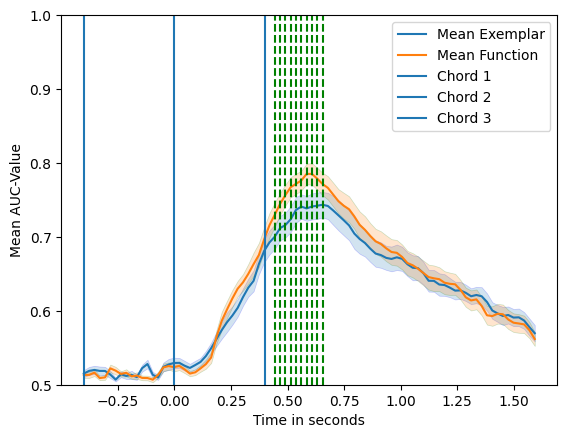

In [5]:
from scipy.stats import ttest_rel
num_features = all_roc_exemplar.shape[1]

# set significance level
alpha = 0.01 # only 1 feature with p-value < 0.01

p_values = np.zeros(num_features)
significant_features = []

for i in range(num_features):
    stat, p = ttest_rel(all_roc_exemplar[:, i], all_roc_function[:, i])
    p_values[i] = p
    
    if p < alpha:
        significant_features.append((i, p))

for feature, p_val in significant_features:
    print(f"Feature {feature} is significant with p-value: {p_val}")

plt.plot(time, mean_roc_exemplar, label="Mean Exemplar")
plt.fill_between(time, mean_roc_exemplar - std_roc_exemplar, mean_roc_exemplar + std_roc_exemplar, alpha=0.2, edgecolor="blue", linewidth=0.5)

plt.plot(time, mean_roc_function, label="Mean Function")
plt.fill_between(time, mean_roc_function - std_roc_function, mean_roc_function + std_roc_function, alpha=0.2, edgecolor="green", linewidth=0.5)

plt.axvline(-0.4, label="Chord 1")
plt.axvline(0, label="Chord 2")
plt.axvline(0.4, label="Chord 3")
for feature, p_val in significant_features:
    plt.axvline(time[feature], color="green", linestyle="--")
plt.ylim((0.5, 1))
plt.ylabel("Mean AUC-Value")
plt.xlabel("Time in seconds")
plt.legend()
plt.show()

## run multiple regression on features

In [10]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd

In [12]:
# X independent features  (target, here we can use attributes from the questionnaire)
# y dependent feature (do we only use the auc values of sign features here?)

# Bring all data in nice form
df = pd.read_csv('data\Questionnaire_Data_JY.csv')
df["P_num"] = df["P_num"] -16
df["AUC"] = None

i = 0
for index in range(40):
    if len(file_paths) > i:
        if ("0" + str(index+1)) in file_paths[i]:
            auc = np.mean(all_roc_function[i, 36:46]) - np.mean(all_roc_exemplar[i, 36:46]) # 38:45
            df.at[index, "AUC"] = auc
            i += 1

# Drop perfect pitch listeners
df = df.drop(df[df.PP == "Y"].index)

# Drop missing subjects
df_for_MR = df.dropna()

# Clean it
for column in ["PianoYears", "ClassHours_18_older", "ImpHours_18_older", "Age", "EHI Score"]:
    df_for_MR[column] = pd.to_numeric(df_for_MR[column], errors='coerce')

# Ensure the dependent variable is also numeric
df_for_MR["AUC"] = pd.to_numeric(df_for_MR["AUC"], errors='coerce')

# Drop any rows that now contain NaNs due to conversion errors (if any)
df_for_MR.dropna(inplace=True)

# Prepare X and y
X = df_for_MR[["PianoYears","ClassHours_18_older","ImpHours_18_older","Age","EHI Score"]]
y = df_for_MR["AUC"]



# Standardize predictors
X_standardized = (X - X.mean()) / X.std()
X_standardized = sm.add_constant(X_standardized)  # Re-add the constant after standardization

# Standardize the response
y_standardized = (y - y.mean()) / y.std()

# Fit the model with standardized variables
model_standardized = sm.OLS(y_standardized, X_standardized).fit()


print(model_standardized.summary())  # For the model with standardized variables


                            OLS Regression Results                            
Dep. Variable:                    AUC   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                 -0.058
Method:                 Least Squares   F-statistic:                    0.7801
Date:                Wed, 07 Feb 2024   Prob (F-statistic):              0.579
Time:                        12:02:56   Log-Likelihood:                -26.859
No. Observations:                  21   AIC:                             65.72
Df Residuals:                      15   BIC:                             71.98
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.958e-17    

C:\Users\NiVaBo\AppData\Local\Temp\ipykernel_8424\684231299.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_MR[column] = pd.to_numeric(df_for_MR[column], errors='coerce')
C:\Users\NiVaBo\AppData\Local\Temp\ipykernel_8424\684231299.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_MR["AUC"] = pd.to_numeric(df_for_MR["AUC"], errors='coerce')
C:\Users\NiVaBo\AppData\Local\Temp\ipykernel_8424\684231299.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

# Forward Model

Exemplar


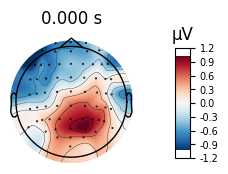

Function


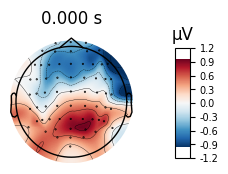

Difference


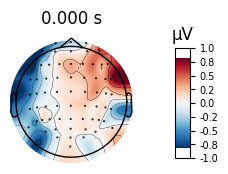

In [41]:
# Step and window size used for generating data
step = 3
window = 7

# Directory where the files are stored
data_dir = "./data"
file_paths = find_txt_files(data_dir, step, window, "forward_model")

# List to store data from all subjects
all_fm_exemplar = []
all_fm_function = []

bad_subjects = ["040"]

# Process each file
for file_name in file_paths:
    if not any(substring in file_name for substring in bad_subjects):

        file_path = data_dir + "/" + file_name
        if os.path.exists(file_path):
            # Read the data from the file
            data = np.loadtxt(file_path)

            exemplar = data[:, 0]
            function = data[:, 1]

            all_fm_exemplar.append(exemplar)
            all_fm_function.append(function)

# Convert lists to NumPy arrays for efficient computation
all_fm_exemplar = np.array(all_fm_exemplar)
all_fm_function = np.array(all_fm_function)

# Compute the mean values using NumPy
mean_fm_exemplar = np.mean(all_fm_exemplar, axis=0)
mean_fm_function = np.mean(all_fm_function, axis=0)

difference_fm = mean_fm_exemplar - mean_fm_function

# Plot it!
ch_names = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7',
 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Afz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',
 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']


info = mne.create_info(ch_names=ch_names, sfreq=128, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage, match_case=False)

print("Exemplar")
data_exemplar = mean_fm_exemplar.reshape(-1, 1)
evoked_exemplar = mne.EvokedArray(data_exemplar, info)
evoked_exemplar.plot_topomap(times=[0], time_unit='s', ch_type='eeg')
plt.show()

print("Function")
data_function = mean_fm_function.reshape(-1, 1)
evoked_function = mne.EvokedArray(data_function, info)
evoked_function.plot_topomap(times=[0], time_unit='s', ch_type='eeg')
plt.show()

print("Difference")
data_difference = difference_fm.reshape(-1, 1)
evoked_difference = mne.EvokedArray(data_difference, info)
evoked_difference.plot_topomap(times=[0], time_unit='s', ch_type='eeg')
plt.show()

In [ ]:
7_3 forward_model

In [18]:
"7_3"in "forward_model_7_3_040.txt" and "forward_model" in "forward_model_7_3_040.txt"

True

# Plot of all individual AUC Curves

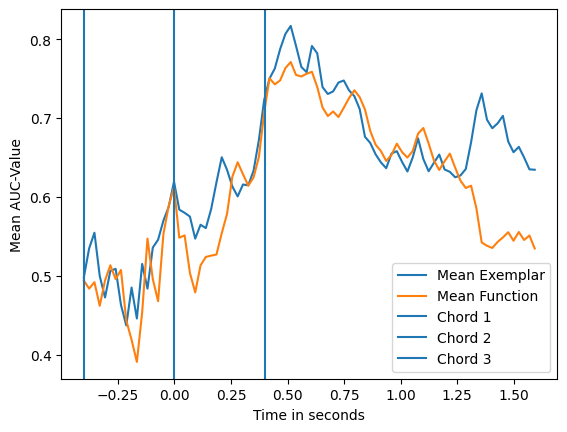

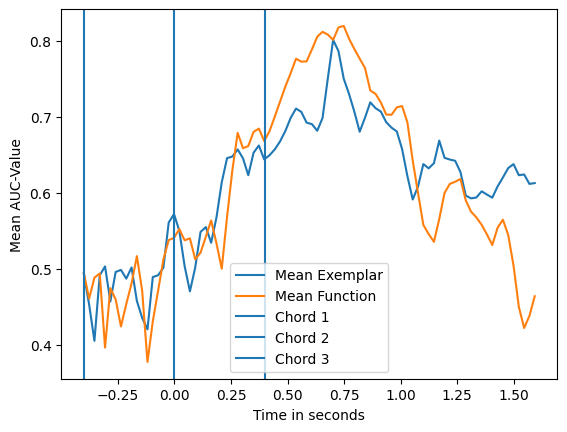

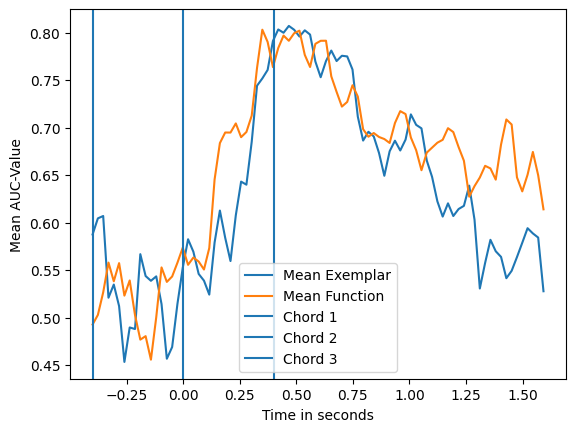

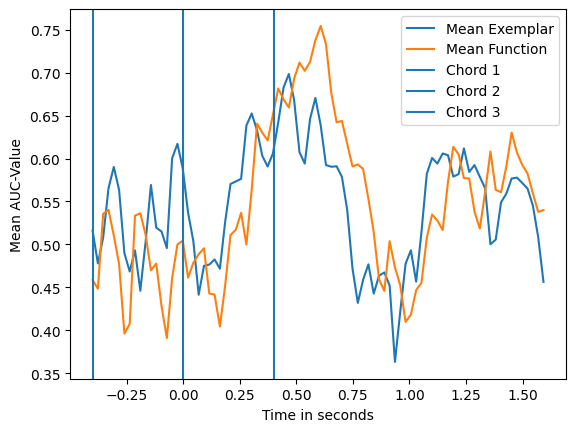

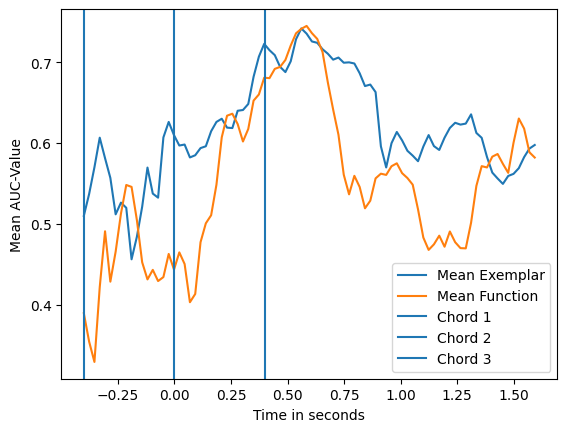

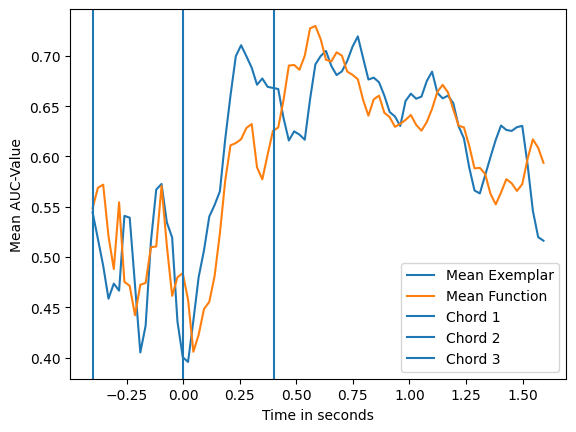

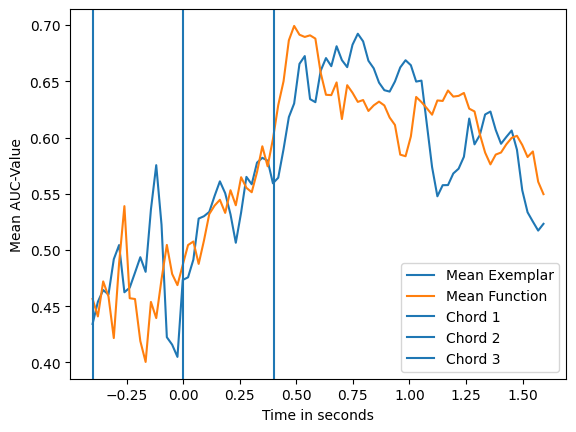

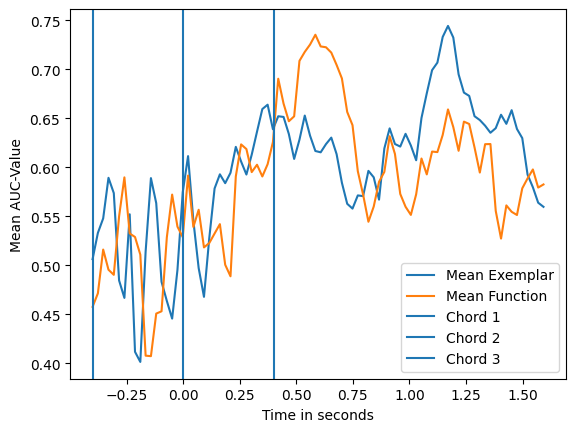

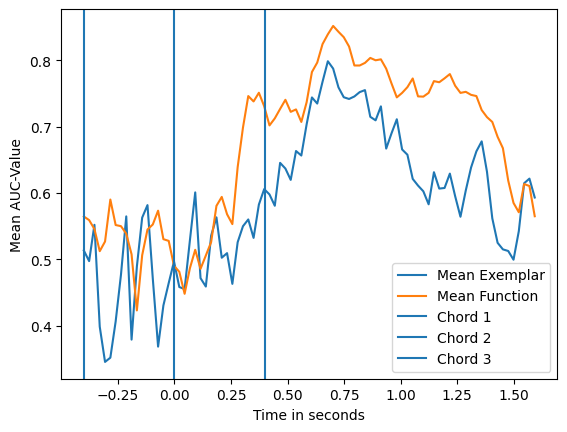

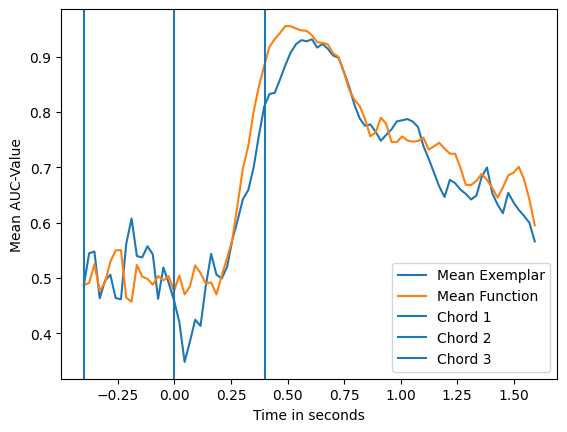

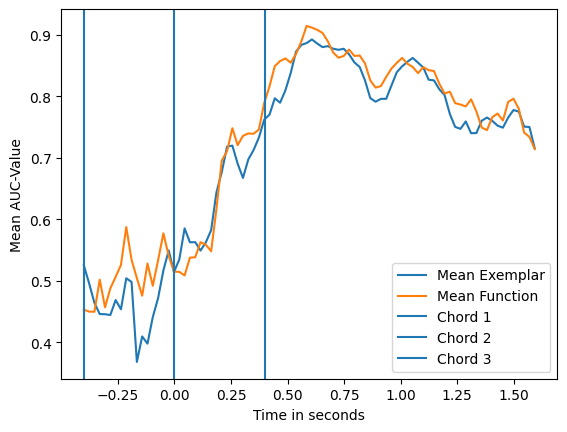

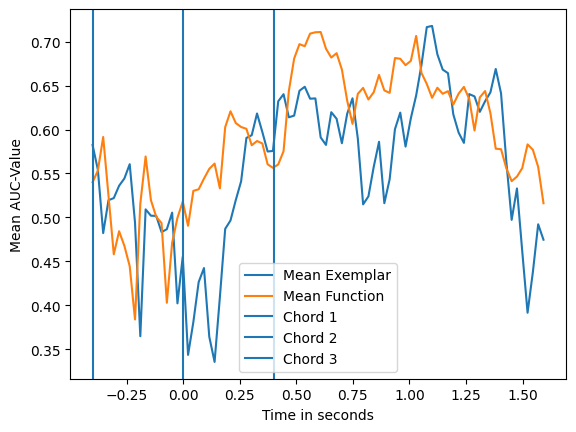

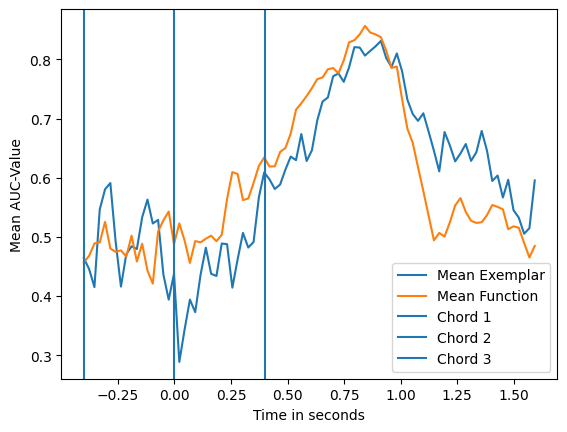

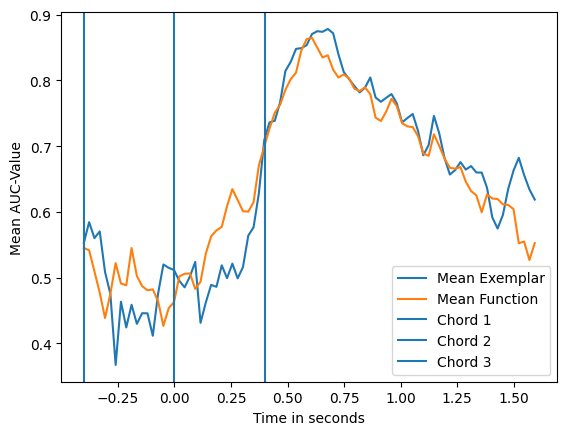

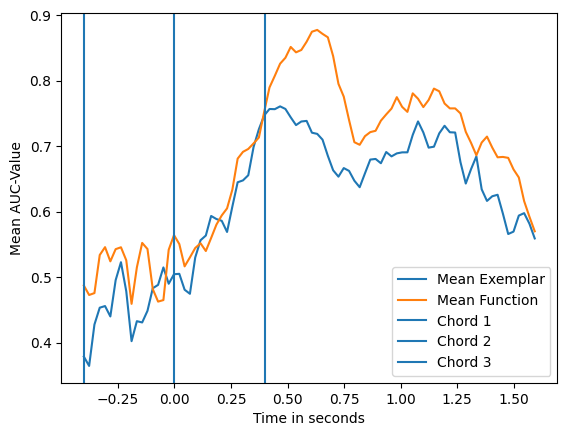

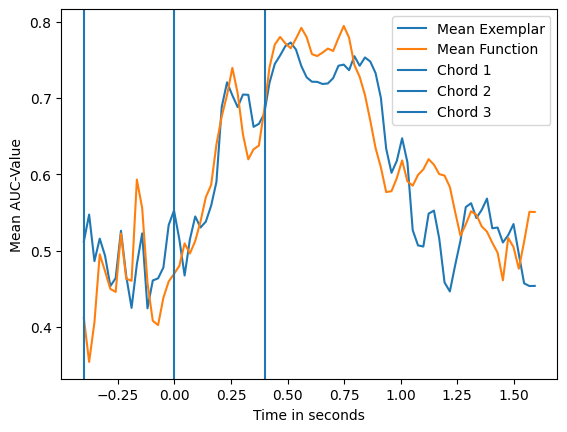

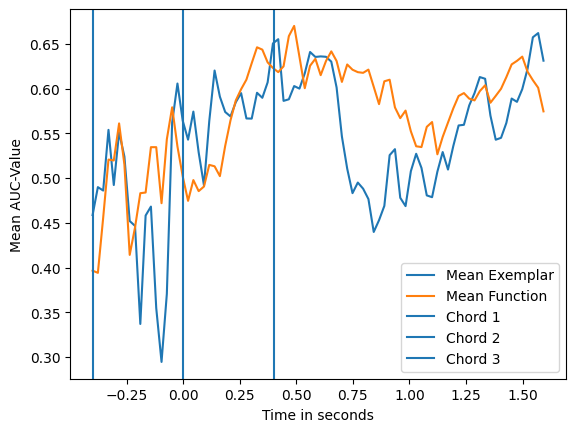

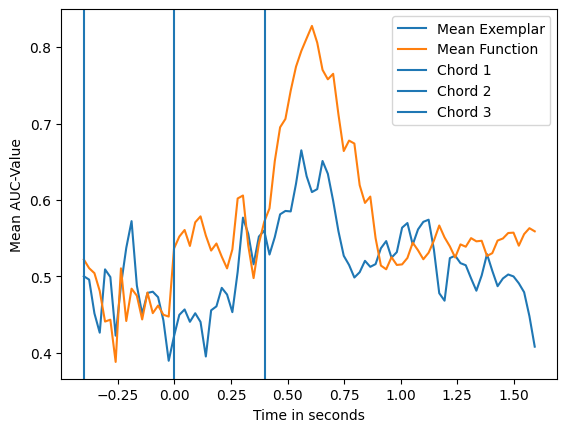

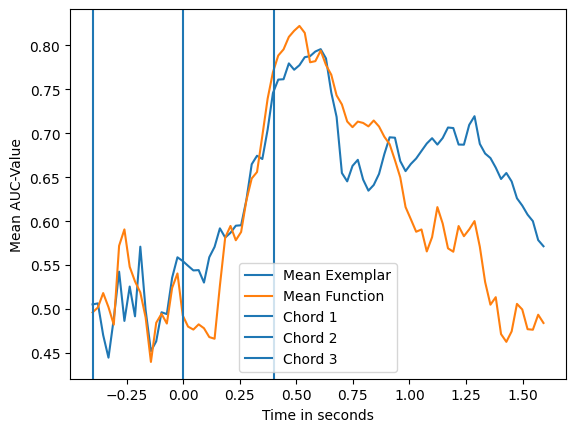

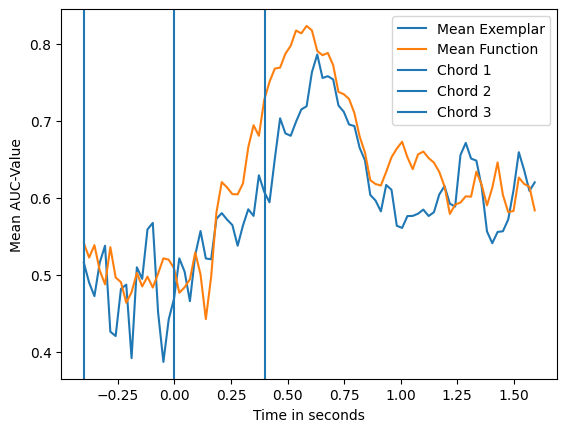

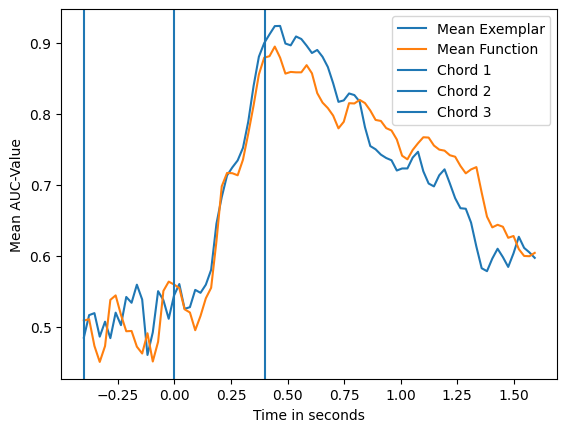

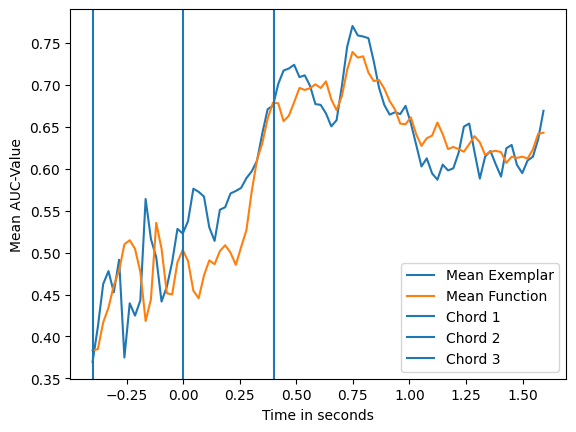

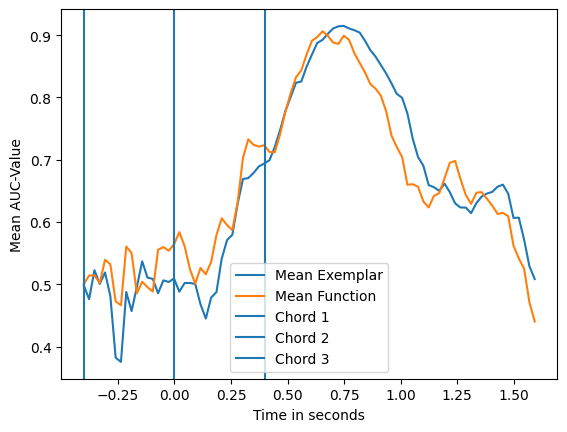

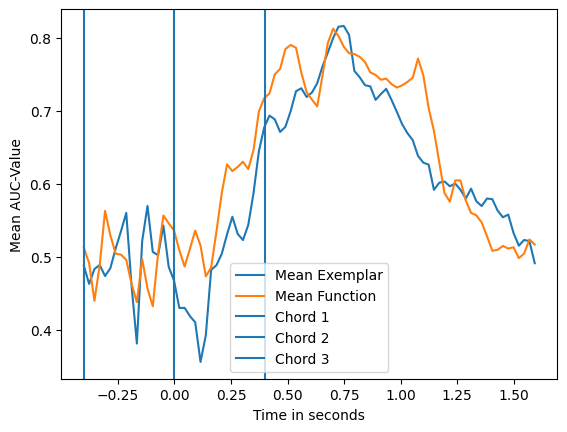

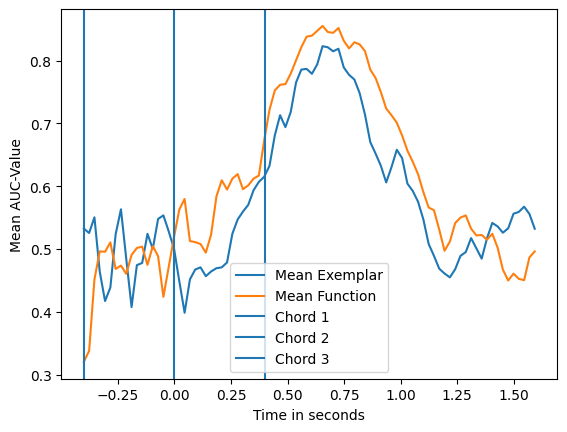

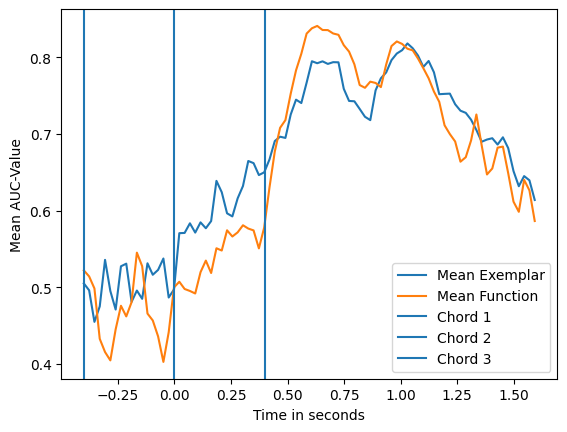

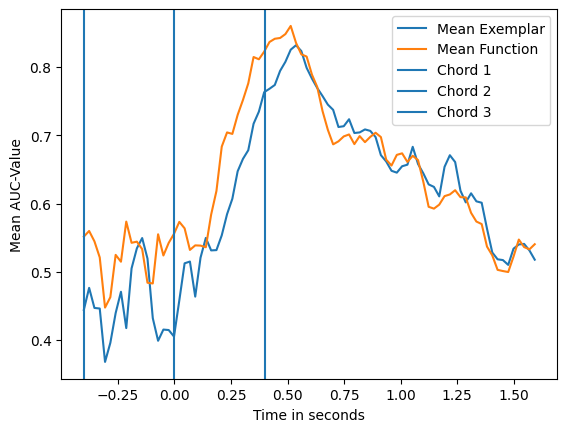

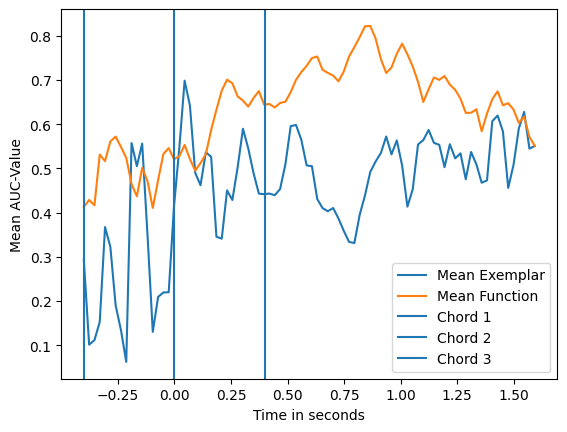

In [5]:
# Step and window size used for generating data
step = 3
window = 7

# Directory where the files are stored
data_dir = "./data"
file_paths = find_txt_files(data_dir, step, window, "auc")


# Process each file
for file_name in file_paths:
    file_path = data_dir + "/" + file_name
    if os.path.exists(file_path):
        # Read the data from the file
        data = np.loadtxt(file_path)
        

        # Generate the time vector
        time = [i * step / 128 - 0.4 for i in range(len(data[:, 0]))]

        # Plotting
        plt.plot(time, data[:, 0], label="Mean Exemplar")
        plt.plot(time, data[:, 1], label="Mean Function")

        plt.axvline(-0.4, label="Chord 1")
        plt.axvline(0, label="Chord 2")
        plt.axvline(0.4, label="Chord 3")
        plt.ylabel("Mean AUC-Value")
        plt.xlabel("Time in seconds")
        plt.legend()
        plt.show()